Consolidate the folds into a single set of results.

In particular, compute the mean and standard deviations of the models in the accuracy, recall and F-score. 

In [1]:
import os
from glob import glob

import numpy as np
import tensorflow as tf

import ScalableLib.classifier.Multiband as multiband
import ScalableLib.base.plot as plot


2024-12-12 23:23:03.644893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 23:23:03.644937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 23:23:03.646323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 23:23:03.655664: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# To reset cuda
# sudo rmmod nvidia_uvm
# sudo modprobe nvidia_uvm
# To see if the system regognises the GPU
device = 0
devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(devices[device], 'GPU')
tf.config.experimental.set_memory_growth(device=devices[device], enable=True)


2024-12-12 23:23:06.271429: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-12 23:23:06.278741: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-12 23:23:06.278936: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Read the Results folder.

In [3]:
survey = 'ZTF'
path = os.path.join('../../03_TrainModels/', survey, 'Results/Fold_*',)
folds = glob(path)
folds.sort()
folds

['../../03_TrainModels/ZTF/Results/Fold_1',
 '../../03_TrainModels/ZTF/Results/Fold_2',
 '../../03_TrainModels/ZTF/Results/Fold_3',
 '../../03_TrainModels/ZTF/Results/Fold_4',
 '../../03_TrainModels/ZTF/Results/Fold_5',
 '../../03_TrainModels/ZTF/Results/Fold_6',
 '../../03_TrainModels/ZTF/Results/Fold_7']

In [4]:
folder_name = 'Results'
path = os.path.join('.', folder_name,'')
if not os.path.exists(path):
    os.mkdir(path)

For each fold, read the models and evaluate on the test set. Save the results

In [5]:
label_order = ['SNIa', 'QSO','AGN', 'Blazar', 'YSO', 'CV/Nova', 'RRL', 'LPV', 'E', ]

In [6]:
# Containers to store the results
reports_folds = []
cm_folds = []
regressions = []
for fold in folds:
    tf.keras.backend.clear_session()
    # Set the fold path
    base_dir = fold+'/'
    
    # Get the last run
    path_runs_folder = os.path.join(base_dir, 'Models', '*')
    path_runs = glob(path_runs_folder)
    path_runs.sort()
    path_run = path_runs[-1]    
    
    path_preprocess = fold.replace('/03_TrainModels/', '/02_CreateRecords/').replace('/Results/', '/Folds/')
    test_files = os.path.join(path_preprocess, 'test/*.tfrecord')
    path_preprocess = os.path.join(path_preprocess, 'metadata_preprocess.json')    

    
    new = multiband.Network()    
    settings_path = os.path.join(path_run, 'all_settings.json')

    fold_name = fold.split('/')[-1]
    write_path = os.path.join('./Results', fold_name+'_Results.dat')
    
    # Get weights path
    run = path_run.split('/')[-1]
    weights_path = os.path.join(fold, 'Models', run)
    new.run_test(settings_path, test_files, weights_path, df_paths = write_path);
    
    
    
    result_path = os.path.join('./Results', fold.split('/')[-1]+'_Results.dat')
    
    # From the results file, read the data and compute the classification scores
    report_fold = plot.compute_classification_report(result_path)
    reports_folds.append(report_fold)
    # From the results file, read the data and compute the confussion matrix and the respective  labels 
    cm_fold = plot.compute_confussion_matrices(result_path, num_classes=new.num_classes, trans=new.trans, labels=label_order)
    cm_folds.append(cm_fold)
    # Extract the regression metrics
    regression = plot.compute_regression(result_path, new.physical_params)
    regressions.append(regression)

2024-12-12 23:23:06.314291: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-12 23:23:06.314539: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-12 23:23:06.314707: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

../../02_CreateRecords/ZTF/Folds/Fold_1/test/*.tfrecord


2024-12-12 23:23:21.686014: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


              precision    recall  f1-score   support

         AGN       0.67      0.61      0.64       484
      Blazar       0.73      0.54      0.62       218
     CV/Nova       0.80      0.80      0.80       152
           E       0.92      0.93      0.92      2000
         LPV       0.99      1.00      0.99      1863
         QSO       0.88      0.91      0.90      2000
         RRL       0.92      0.93      0.92      2000
        SNIa       1.00      0.93      0.96       101
         YSO       0.86      0.76      0.81       159

    accuracy                           0.91      8977
   macro avg       0.86      0.82      0.84      8977
weighted avg       0.91      0.91      0.91      8977

{'R2': {'T_eff': 0.7443692684173584, 'Radius': 0.7556018829345703}, 'RMSE': {'T_eff': 494.76273, 'Radius': 9.566965}}
../../02_CreateRecords/ZTF/Folds/Fold_2/test/*.tfrecord
              precision    recall  f1-score   support

         AGN       0.59      0.54      0.56       484
      Blazar

In [7]:
median, delta_up, delta_down = plot.obtain_accumulated_metrics(reports_folds, metric='median', label_order=label_order)
display(median)
display(delta_up)
display(delta_down)

,SNIa,QSO,AGN,Blazar,YSO,CV/Nova,RRL,LPV,E
precision,1.00,0.88,0.62,0.64,0.79,0.69,0.91,0.99,0.90
recall,0.92,0.89,0.58,0.54,0.72,0.80,0.91,0.99,0.91
f1-score,0.96,0.89,0.60,0.58,0.75,0.73,0.91,0.99,0.91
support,101.00,2000.00,484.00,218.00,159.00,152.00,2000.00,1863.00,2000.00


,SNIa,QSO,AGN,Blazar,YSO,CV/Nova,RRL,LPV,E
precision,0.000000,0.003091,0.003350,0.055573,0.035591,0.022544,0.004258,0.000829,0.008015
recall,0.019802,0.003500,0.016529,0.006881,0.040881,0.009868,0.004250,0.002952,0.002500
f1-score,0.008288,0.001958,0.008572,0.025526,0.036319,0.030312,0.004253,0.000517,0.005298
support,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,SNIa,QSO,AGN,Blazar,YSO,CV/Nova,RRL,LPV,E
precision,0.010101,0.004322,0.040738,0.034536,0.010784,0.024710,0.013802,0.000493,0.008980
recall,0.004950,0.012250,0.023760,0.011468,0.018868,0.006579,0.008000,0.000537,0.014000
f1-score,0.005395,0.011163,0.036843,0.014949,0.002543,0.006274,0.013462,0.001091,0.014429
support,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
np.round(median.loc['f1-score'].mean(),3)

0.813

<Figure size 640x480 with 0 Axes>

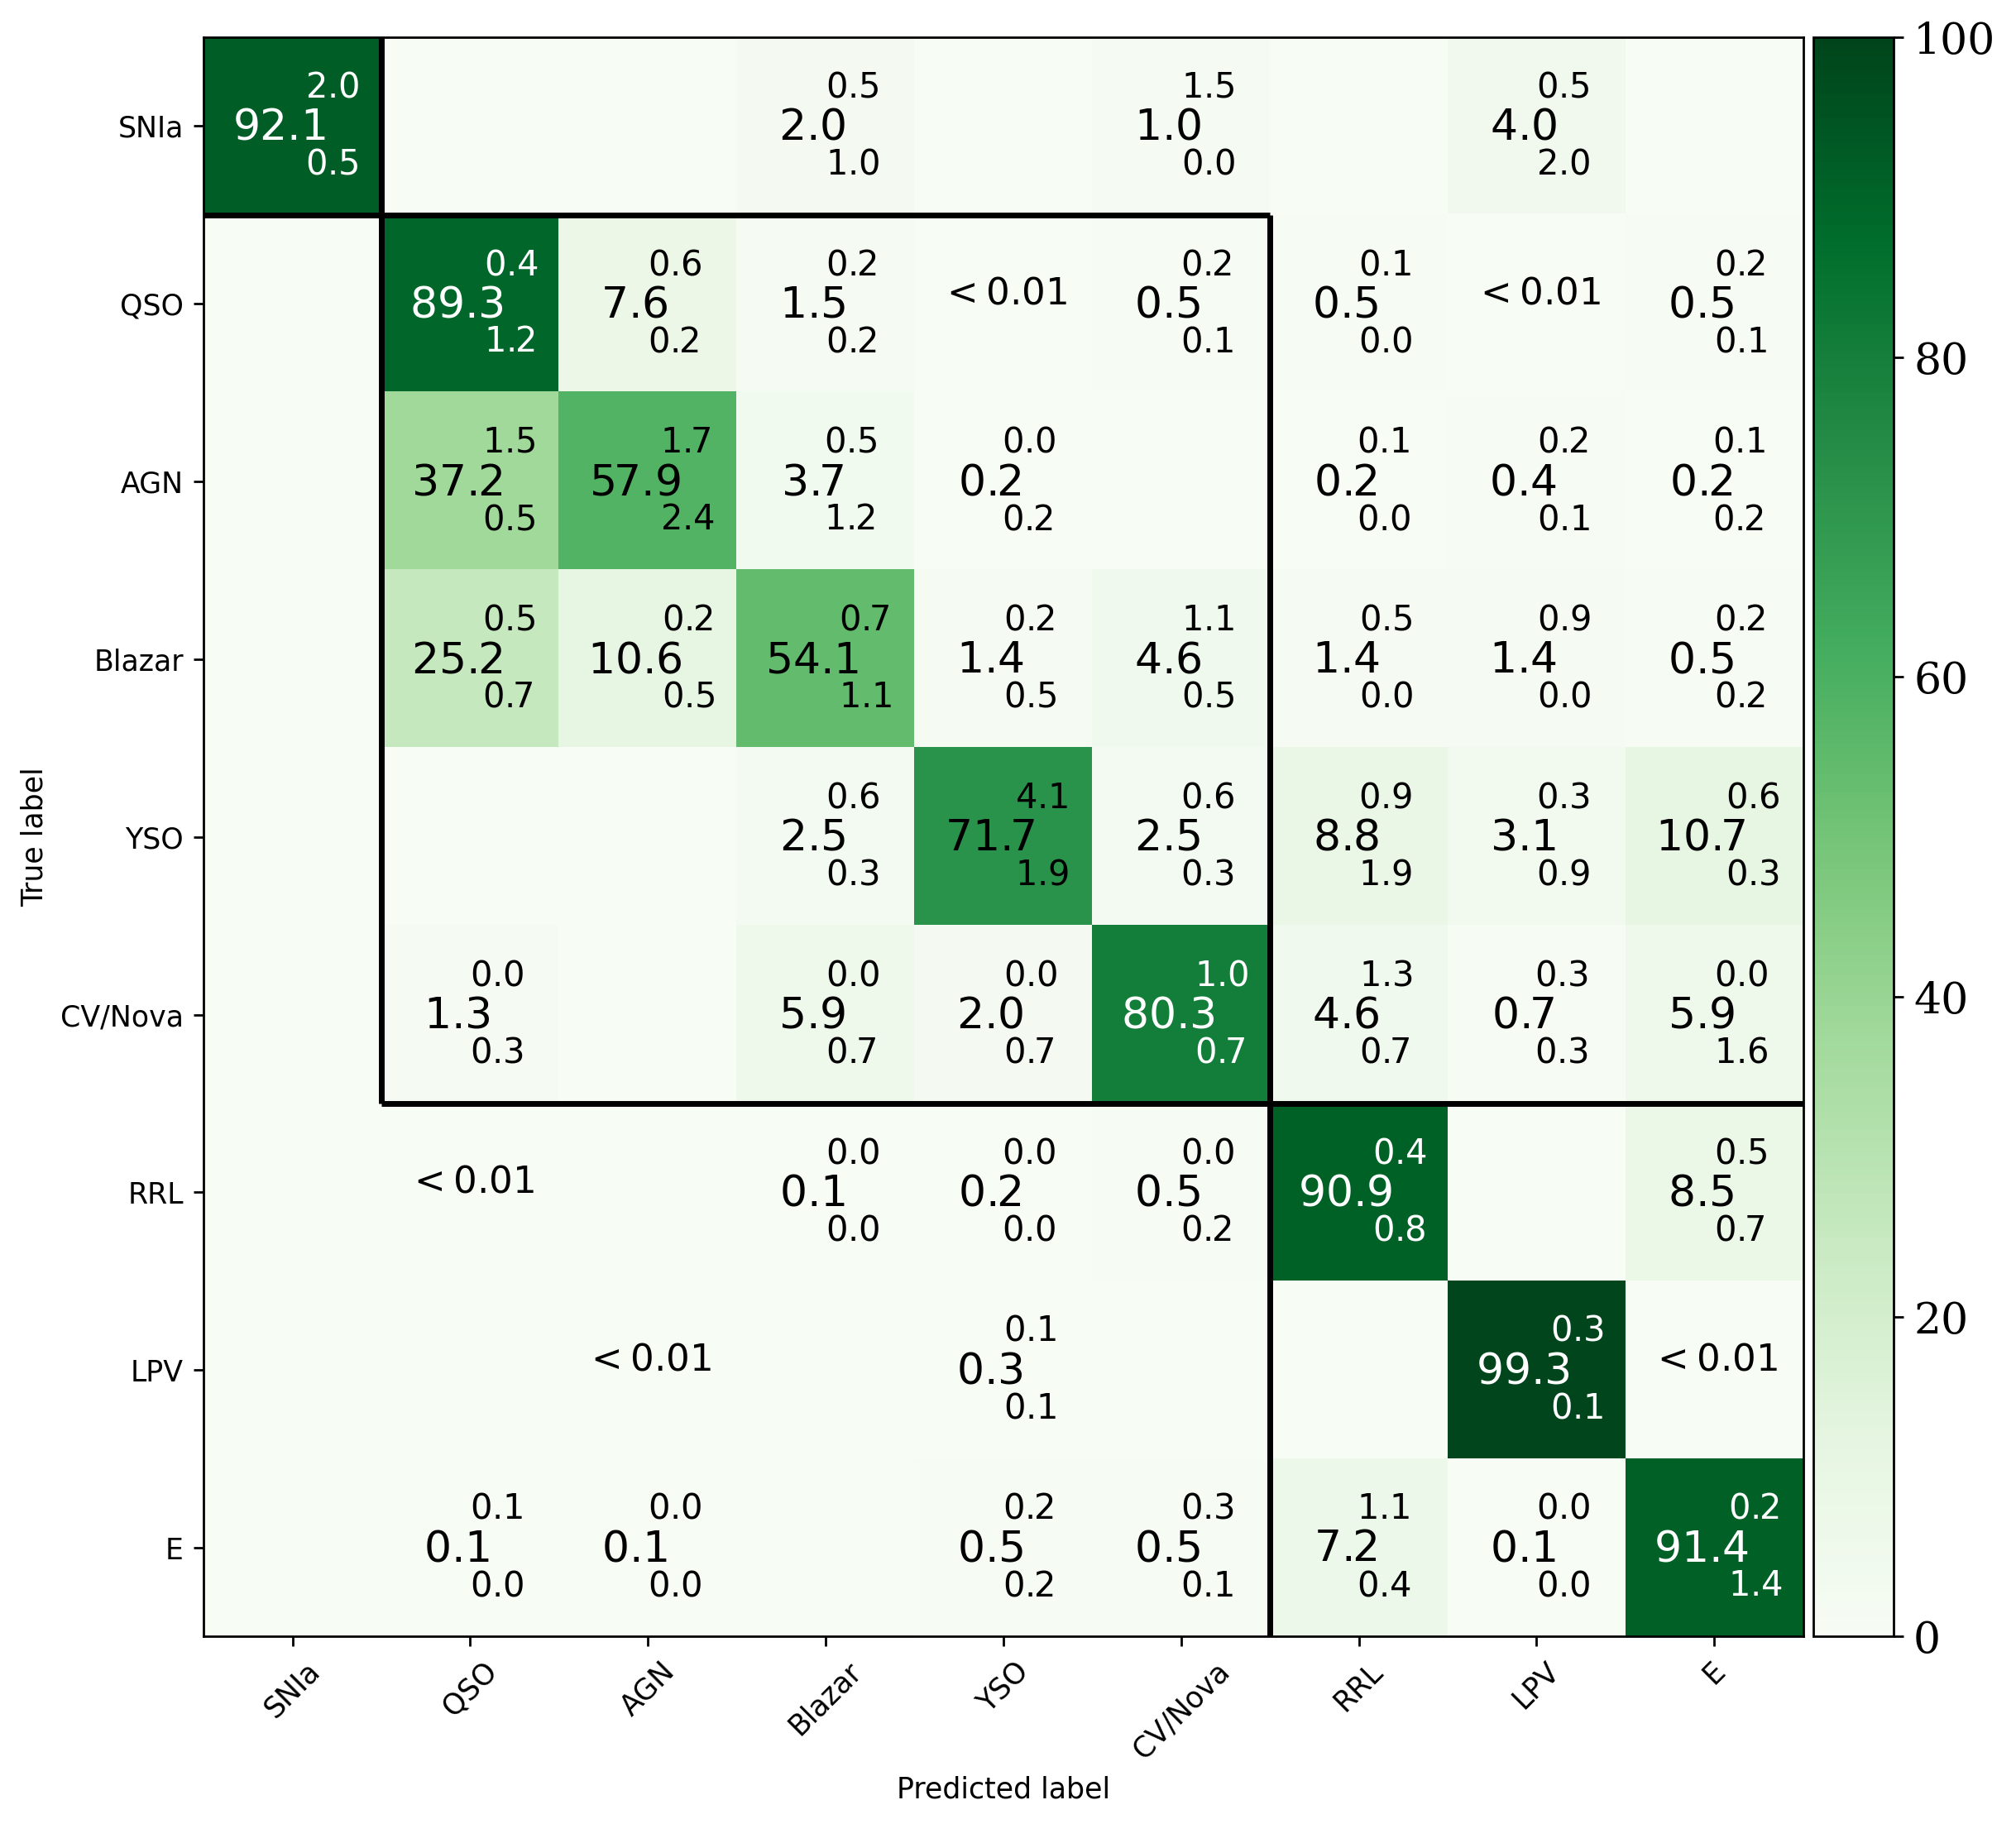

In [9]:
statistic = 'median'
img_path = './'+survey+'_'+statistic+'_c.pdf'
plot.plot_confusion_matrix(cm_folds, labels_=label_order, survey='ZTF', statistic=statistic, save_path=img_path)

In [10]:
accuracies = [reports_folds[i]['accuracy'] for i in range(len(reports_folds))]
np.round(np.median(accuracies),4), np.round(np.mean(accuracies),4)


(0.8933, 0.8893)

In [11]:
macro_avg_recall = [reports_folds[i]['macro avg']['recall'] for i in range(len(reports_folds))]
np.round(np.median(macro_avg_recall),4), np.round(np.mean(macro_avg_recall),4)

(0.8078, 0.8068)

In [12]:
regression_metrics = plot.obtain_accumulated_regressions(regressions, metric='median')
print('median')
display(regression_metrics[0])
print('75-percentile')
display(regression_metrics[1])
print('25-percentile')
display(regression_metrics[2])


median


,R2,RMSE,MAPE
T_eff,0.739035,499.897831,0.062696
Radius,0.756550,9.548383,0.784166


75-percentile


,R2,RMSE,MAPE
T_eff,0.004721,7.536230,0.001046
Radius,0.007560,0.057128,0.043702


25-percentile


,R2,RMSE,MAPE
T_eff,0.007953,4.542935,0.000212
Radius,0.002926,0.149492,0.004073
